#Transfer Learning with **VGG16 Training**(True) and **data augmentation** (True)


1.   Epochs=50
2.   Learning rate=0.0005
1.   Image size=(200,200)
2.   Image=Grayscale
1.   Defect_classes=['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
1.   batch_size=16
1.   optimizer=adam





















# Importing the libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data organised in folders

# Folder path and location

In [2]:
#for desktop
#path=r'./NEU Metal Surface Defects Data' 

In [3]:
# accessing data from colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# folder path for colab
path=r'/content/drive/MyDrive/Colab Notebooks/Tlab/NEU Metal Surface Defects Data'

# Contents and data organization within folder

In [5]:
print("Main Folder")
os.listdir(path)

Main Folder


['Thumbs.db', 'valid', 'test', 'train']

In [6]:
print("Train sub-folder")
os.listdir(path+'/train')

Train sub-folder


['Pitted', 'Patches', 'Inclusion', 'Crazing', 'Scratches', 'Rolled']

In [7]:
classes_defects=os.listdir(path+'/train')
print(classes_defects)

['Pitted', 'Patches', 'Inclusion', 'Crazing', 'Scratches', 'Rolled']


In [8]:
print("files within sub-folder Patches")
os.listdir(path+'/train/Patches')[:3]

files within sub-folder Patches


['Pa_238.bmp', 'Pa_262.bmp', 'Pa_130.bmp']

In [9]:
len(os.listdir(path+'/train'))

6

# Image characteristics

In [10]:
img1=Image.open(path+'/train/Patches/Pa_206.bmp')
print(img1.filename)
print(img1.format)
print(img1.mode)
print(img1.size)

# # The "L" mode represents grayscale here.... So it can hold any of 256 shades of Gray 
# (includes black and white as Gray shades).
# # The "P" mode can hold 256 different colors like red,blue, green etc....
# https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil#:~:text=Examples%3A%208%20bit%20black%20and,are%20%22P%22%20mode..

/content/drive/MyDrive/Colab Notebooks/Tlab/NEU Metal Surface Defects Data/train/Patches/Pa_206.bmp
BMP
L
(200, 200)


(200, 200)
max_pixel_value: 255


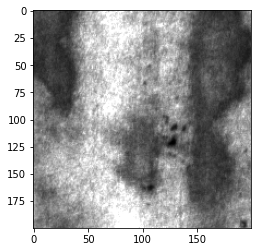

In [11]:
image=plt.imread(path+'/train/Patches/Pa_206.bmp')
print(image.shape)
plt.imshow(image,cmap='gray')
print("max_pixel_value: {}".format(image.max()))

# ImageDataGenerator and flow_from_directory for datasets

Sources:

1.   https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
2.   https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/TensorFlow/Basics/tutorial18-customdata-images/1_in_subfolders.py



In [12]:
data_generator=ImageDataGenerator(
    rescale=1.0/255,
    dtype=tf.float32
)

# Train dataloader

In [13]:
train_ds=data_generator.flow_from_directory(
    path+'/train',
    target_size=(200,200),
    # color_mode='grayscale',
    classes=classes_defects,
    class_mode='sparse',
    shuffle=True,
    seed=1,
    batch_size=16
)

Found 1667 images belonging to 6 classes.


# Valid dataloader

In [14]:
valid_ds=data_generator.flow_from_directory(
    path+'/valid',
    target_size=(200,200),
    # color_mode='grayscale',
    classes=classes_defects,
    class_mode='sparse',
    shuffle=True,
    seed=1,
    batch_size=16
)

Found 72 images belonging to 6 classes.


# Test dataloader

In [59]:
test_ds=data_generator.flow_from_directory(
    path+'/test',
    target_size=(200,200),
    # color_mode='grayscale',
    classes=classes_defects,
    class_mode='sparse',
    shuffle=False,
    seed=1,
    batch_size=1
)

Found 72 images belonging to 6 classes.


# Dataloader sanity check

In [16]:
print("Dataloader_length(Images,labels)", len(train_ds[0]))
print("image list length",len(train_ds[0][0]))
print("image shape", train_ds[0][0].shape)
print("Defect List: ",classes_defects)
print("Defect dictionary in dataloader: ",train_ds.class_indices)
print(train_ds.labels[1660])
print(train_ds.classes)
print(train_ds.class_indices.keys())
print(train_ds.class_indices.values())
#print([train_ds.class_indices(x)] for x in train_ds.classes])

Dataloader_length(Images,labels) 2
image list length 16
image shape (16, 200, 200, 3)
Defect List:  ['Pitted', 'Patches', 'Inclusion', 'Crazing', 'Scratches', 'Rolled']
Defect dictionary in dataloader:  {'Pitted': 0, 'Patches': 1, 'Inclusion': 2, 'Crazing': 3, 'Scratches': 4, 'Rolled': 5}
5
[0 0 0 ... 5 5 5]
dict_keys(['Pitted', 'Patches', 'Inclusion', 'Crazing', 'Scratches', 'Rolled'])
dict_values([0, 1, 2, 3, 4, 5])


Image_shape:  (16, 200, 200, 3)
Label_value:  3.0
['Pitted', 'Patches', 'Inclusion', 'Crazing', 'Scratches', 'Rolled']
tf.Tensor([3 0 5 3 0 3 0 5 4 2 0 3 4 3 0 1], shape=(16,), dtype=uint8)
Crazing


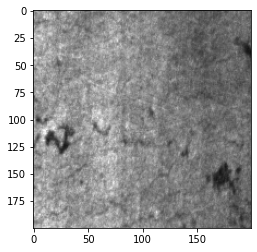

In [17]:
for images,labels in train_ds:
  plt.imshow(images[0],cmap='gray')
  print("Image_shape: ",images.shape)
  print("Label_value: ",labels[0])
  labels=tf.cast(labels,tf.uint8)
  print(classes_defects)
  print((labels))
  print(classes_defects[labels[0]])
  break

In [18]:
#

# Model architecture and Pretrained model import from keras

Sources:


1.   https://keras.io/api/applications/
2.   https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673



In [19]:
from tensorflow.keras.applications import VGG16

In [20]:
feature_extractor=VGG16(weights='imagenet',input_shape=(224,224,3),include_top=True) #end layer of 1000, no need for average pooling
feature_extractor.trainable=True

553476096/553467096 [==============================] - 3s 0us/step


In [21]:
data_aug=keras.Sequential([
                           tf.keras.Input(shape=(200,200,3)),
                           layers.experimental.preprocessing.Resizing(height=224,width=224),
                           layers.experimental.preprocessing.RandomContrast(factor=0.25),
                           layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
                           layers.experimental.preprocessing.RandomZoom(0.5,0.6),
                           layers.experimental.preprocessing.RandomRotation(0.5),
                           layers.experimental.preprocessing.RandomTranslation(0.2,0.2),

])

In [22]:
input_=tf.keras.Input(shape=(200,200,3))
x=data_aug(input_)
x=feature_extractor(x,training=True)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(64,activation='relu')(x)
x=layers.Dense(32,activation='relu')(x)
output_=layers.Dense(6)(x)

In [23]:
model=keras.Model(input_,output_)

# Final Model architecture summary

In [24]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198   

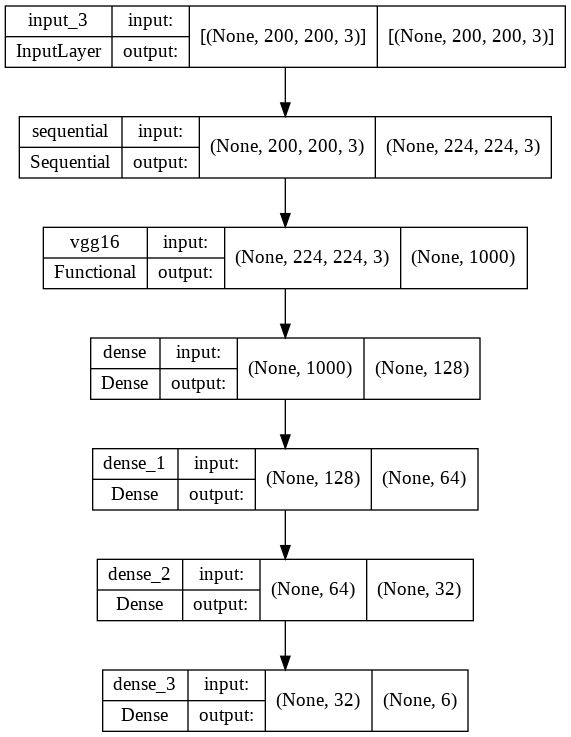

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Model training

In [26]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.0005),
              metrics=['accuracy'])

In [27]:
history=model.fit(train_ds, epochs=50, verbose=True,validation_data=valid_ds)

Epoch 1/50
105/105 [==============================] - 588s 5s/step - loss: 1.7933 - accuracy: 0.1494 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 2/50
105/105 [==============================] - 26s 249ms/step - loss: 1.7927 - accuracy: 0.1602 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/50
105/105 [==============================] - 26s 245ms/step - loss: 1.7922 - accuracy: 0.1674 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 4/50
105/105 [==============================] - 26s 243ms/step - loss: 1.7923 - accuracy: 0.1596 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 5/50
105/105 [==============================] - 26s 243ms/step - loss: 1.7924 - accuracy: 0.1668 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 6/50
105/105 [==============================] - 26s 244ms/step - loss: 1.7925 - accuracy: 0.1542 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 7/50
105/105 [==============================] - 26s 243ms/step - loss: 1.7921 - accuracy: 0.1590 - val_loss: 1.7918 - val_accu

# Test dataloader evaluation, Saving and loading weights

In [28]:
model.evaluate(test_ds)

5/5 [==============================] - 23s 6s/step - loss: 1.7918 - accuracy: 0.1667


[1.7917646169662476, 0.1666666716337204]

In [29]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Tlab')

In [30]:
# For creating new directory
#os.makedirs('VGG16/VGG16_training_true_aug_true')

In [31]:
os.chdir('./VGG16/VGG16_training_true_aug_true')

In [32]:
#For saving weights
model.save_weights('training_vgg_03.ckpt')

## Loading Weights

In [33]:
model_new=keras.Model(input_,output_)

In [34]:
model_new.load_weights('./training_vgg_03.ckpt')

In [35]:
model_new.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(0.0005),
              metrics=['accuracy'],
              )

In [36]:
# os.getcwd()

In [37]:
# #2x
# os.chdir(r'..')
# print(os.getcwd())

In [38]:
#test batch size=16
model_new.evaluate(test_ds)

5/5 [==============================] - 1s 86ms/step - loss: 1.7918 - accuracy: 0.1667


[1.7917646169662476, 0.1666666716337204]

In [58]:
#test batch size=72
model_new.evaluate(test_ds)

1/1 [==============================] - 5s 5s/step - loss: 1.7918 - accuracy: 0.1667


[1.7917646169662476, 0.1666666716337204]

In [60]:
#test batch size=1
model_new.evaluate(test_ds)

72/72 [==============================] - 2s 15ms/step - loss: 1.7918 - accuracy: 0.1667


[1.7917649745941162, 0.1666666716337204]

# Performance

In [ ]:
history.history.keys()

Loss vs epochs

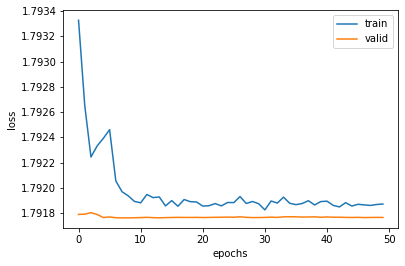

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','valid'])

Accuracy vs epochs

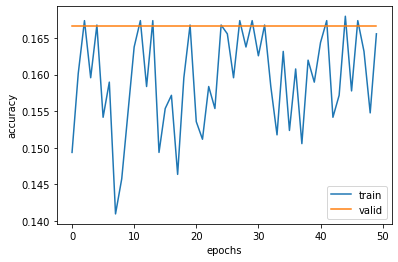

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','valid'])

# Predictions

In [44]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

In [45]:
X_test=[]
y_test=[]
for i in range(len(test_ds)):
  dataiter = iter(test_ds)
  images, labels = dataiter.next()
  X_test.extend(images)
  y_test.extend(labels)

In [46]:
print(len(X_test))

72


In [47]:
y_test=[int(x) for x in y_test]
print(y_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [48]:
y_predict=model_new.predict(np.array(X_test))
print(y_predict[:2])
y_hat=[np.argmax(x) for x in y_predict]
print(y_hat)

[[-0.00408164 -0.00507699 -0.00208092  0.00187704  0.00355869  0.00166225]
 [-0.00408164 -0.00507699 -0.00208092  0.00187704  0.00355869  0.00166225]]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [ ]:
print(classification_report(y_test, y_hat, target_names=classes_defects))

In [ ]:
print(confusion_matrix(y_test, y_hat))

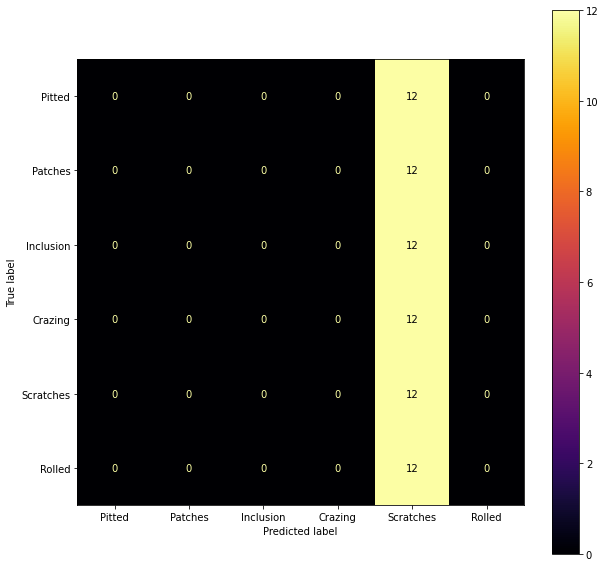

In [51]:
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat),display_labels=classes_defects)
fig,ax=plt.subplots(figsize=(10,10))
cmd.plot(ax=ax,cmap="inferno")

In [52]:
# X_test,y_test=next(iter(test_ds))

In [53]:
# print(X_test.shape)

In [54]:
# print(y_test)

In [55]:
# y_predict=model.predict(X_test)
# print(y_predict[:2])
# y_hat=[np.argmax(x) for x in y_predict]
# print(y_hat)

In [56]:
# import numpy as np
# sample=np.expand_dims(X_test[1],axis=0)
# print(sample.shape)
# sample_predict=model.predict(sample)
# print(sample_predict.shape)
# plt.imshow(X_test[0],cmap='gray')
# print(sample_predict, "Max: ", np.argmax(sample_predict))
# print("predicted label: ",classes_defects[np.argmax(sample_predict)])
# print("Actual label: ",classes_defects[int(y_test[1])])